# 3D-PINNS - FUNCTIONAL DATA ANALYSIS PHYSICS-INFORMED NEURAL NETWORKS
In this notebook, I briefly explain Functional Data Analysis Physics-Informed Neural Networks (3D-PINNS). This novel method was developed under supervision of Dr. Michelle Carey during my MSc in Data Science in University College Dublin, Ireland. It uses techniques from Functional Data Analysis (FDA) and Physics-Informed Neural Networks (PINNs) to estimate the underlying signal from noisy measurements of a quantity of interest on three-dimensional surface meshes. Our motivating application was neuroimaging, where cutting-edge medical software generates a digital mesh representing the intricate three-dimensional structure of a patient's brain and also records brain activation levels on it. 

# Data presentation

The Human Connectome Project (HCP) [1-4] is an open-source dataset that consists of high-resolution neuroimaging scans of 1200 healthy young adults aged between 22-35 years old. The brain activity of subjects during periods of rest or while conducting a task is captured as a time series via functional Magnetic Resonance Imaging (fMRI) using blood-oxygen-level-dependent (BOLD) signals. The fMRISurface [2] preprocessing pipeline uses the fMRI scans to create a three-dimensional mesh model of each subject's brain. The BOLD signal is mapped to each vertex of the cortical mesh, culminating in a sophisticated three-dimensional surface overlaid with brain activity data. The HCP dataset is freely available at https://www.humanconnectome.org/.

For this example notebook, we downloaded the brain mesh of the left hemisphere of a subject conducting a language task, where they listened to a short story and were asked to answer questions about it. This was alternated with simple math problems, to which the subject was questioned about the correct answer [5]. The mesh contains 32,492 vertices and the time series contains 316 time points. 

Let us visualize the brain mesh. We first import all the necessary modules. We use PyTorch for the deep learning aspect of our novel method and PyVista for plotting.

In [2]:
# =========================================================================================================================
# IMPORTING LIBRARIES
# =========================================================================================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import scipy.special
import time

# Plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pyvista as pv

In [3]:
# =========================================================================================================================
# GETTING MESH
# =========================================================================================================================
FACES = np.loadtxt("faces.csv",delimiter=",").astype(int) # faces
VERTICES = np.loadtxt("vertices.csv",delimiter=",") # vertices
# =========================================================================================================================
# DATA ON MESH
# =========================================================================================================================
data = np.loadtxt("data.csv",delimiter=",") # data
data = np.array([0 if -.7 <= x <= .7 else x for x in data]) # thresholded at .7

PyVista's plotter is interactive. You can zoom in and out and rotate the brain mesh to better visualize the vertices and edges forming the triangles in the mesh.

In [4]:
# =========================================================================================================================
# PLOTTING DATA - BRAIN MESH
# =========================================================================================================================
%matplotlib notebook

# Faces matrix must contain number of vertices in each face as first element in PyVista
organ = pv.PolyData(VERTICES, np.append(np.array([3*np.ones(FACES.shape[0],dtype="int64")]),FACES.T,axis=0).T)

sargs = dict(
    color="black"
)

pl = pv.Plotter()
pl.add_mesh(organ,
            show_edges=True,
            cmap="bwr",scalar_bar_args=sargs)

pl.set_background('white')

pl.show()

Widget(value='<iframe src="http://localhost:63804/index.html?ui=P_0x1e3b7aea700_0&reconnect=auto" class="pyvis…

The above plot shows the triangulated mesh representing the subject's brain. Notice how the mesh is able to accurately capture the shape complexities of the brain surface. The plot below shows one frame of the mean-centered time series of the BOLD signal overlaid on top of the surface. The values displayed are proportional to activity levels on the brain at that time frame. In other words, the color red represents brain areas that have higher activity than average while the color blue represents brain areas with less activity than average.

In [5]:
# =========================================================================================================================
# PLOTTING DATA - BRAIN MESH + BOLD SIGNAL (ACTIVITY LEVELS)
# =========================================================================================================================
%matplotlib notebook

organ.point_data['Data'] = data

sargs = dict(
    color="black"
)

pl = pv.Plotter()
pl.add_mesh(organ,
            scalars="Data",
            show_edges=False,
            cmap="bwr",scalar_bar_args=sargs)

pl.set_background('white')

pl.show()

Widget(value='<iframe src="http://localhost:63804/index.html?ui=P_0x1e38fdd88b0_1&reconnect=auto" class="pyvis…

The above plot makes it clear that the BOLD signal is considerably contaminated by noise. This is due to the fact that recording of the fMRI images and later preprocessing to generate such three-dimensional surface models introduce noise in the data. Since images like the ones above are used routinely in medical research, recovering the underlying BOLD signal is paramount for specialists to draw correct conclusions from their patients' data. That is the goal of 3D-PINNS.

# Model
Functional Data Analysis (FDA) is the area of statistics that studies random variables represented by curves and surfaces. Let $\bm{r}_i=(x_i,y_i,z_i)\in \Omega\subset\mathbb{R}^3$, $i=1,2,...,N_p$, be the points in the three-dimensional brain surface mesh $\Omega$ and let $s_i$ denote the noise-contaminated BOLD signal measured at those points. Following the FDA framework, the data are assumed to be derived from an underlying continuous smooth function $f(\bm{r})$ representing the true BOLD signal on the brain surface:

$$
s_i = f(\bm{r}_i) + \epsilon_i,~~~~~~~ (1)
$$

where the error $\epsilon_i$ follows a normal distribution $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$ with mean zero and variance $\sigma^2$ and errors associated to different points are assumed independent.

Our novel approach estimates $f$ based on a cost function introduced in [6,7]. It is given by:

$$
\mathcal{L}[f]=\displaystyle\sum_{i=1}^{N_p}\left(s_i-f(\overrightarrow{r}_i)\right)^2+\lambda\int_\Omega\left(\overrightarrow{\nabla}^2f\right)^2d\overrightarrow{r}.~~~~~~~ (2)
$$

In Equation (2), the first term is a standard least-squares representing the agreement between the smooth function and the data values. The second term involves the Laplace-Beltrami operator $\overrightarrow{\nabla}^2$, which is a generalization of the Laplace operator for surfaces [8]. The operator $\overrightarrow{\nabla}^2$ measures the curvature of $f(\overrightarrow{r})$ when the domain $\Omega$ itself is curved. The smoothing parameter $\lambda$ controls the trade-off between both terms in the above equation. When $\lambda\rightarrow0$, the least-squares term dominates and the estimate tends to be close to the data. For $\lambda\rightarrow\infty$, the penalty is more important and the estimate tends to a constant function with zero curvature on the surface.


Minimizing the cost function in Equation (2) is equivalent to solving the following equation:

$$
\displaystyle\sum_{i=1}^{N_p}\left(s_i-f(\overrightarrow{r}_i)\right)\delta\left(\overrightarrow{r}-\overrightarrow{r}_i\right)=\lambda \overrightarrow{\nabla}^4f,~~~~~~~ (3)
$$

where $\delta(\overrightarrow{r})$ is Dirac's delta function and $\overrightarrow{\nabla}^4f\equiv\overrightarrow{\nabla}^2\left(\overrightarrow{\nabla}^2f\right)$. 

It is convenient to define an auxiliary function $g(\overrightarrow{r})\equiv\overrightarrow{\nabla}^2f$ to decrease the order of the problem. We can then write:

$$
\left\{\begin{array}{c}
        \displaystyle\sum_{i=1}^{N_p}\left(s_i-f(\overrightarrow{r}_i)\right)\delta\left(\overrightarrow{r}-\overrightarrow{r}_i\right)=\lambda \overrightarrow{\nabla}^2g, \\
        \overrightarrow{\nabla}^2f=g(\overrightarrow{r}).
    \end{array}\right.~~~~~~~ (4)
$$


Introducing functions $u(\overrightarrow{r})$ and $v(\overrightarrow{r})$ also defined on the domain $\Omega$, we can write Equation (4) in its weak form [10] by integrating both sides over the entire domain $\Omega$:

$$
\left\{\begin{array}{c}
        \displaystyle\sum_{i=1}^{N_p}\left(s_i-f(\overrightarrow{r}_i)\right)u(\overrightarrow{r}_i)-\lambda\int_\Omega u(\overrightarrow{r})\overrightarrow{\nabla}^2g\text{ }d\overrightarrow{r}=0,\\
        \\
        \displaystyle\int_\Omega v(\overrightarrow{r})\overrightarrow{\nabla}^2f\text{ }d\overrightarrow{r}-\displaystyle\int_\Omega v(\overrightarrow{r})g(\overrightarrow{r})\text{ }d\overrightarrow{r}=0. 
    \end{array}\right.~~~~~~~ (5)
$$

Let $I_\Delta$ be the set of $N_T$ triangles $t_{ijk}$ composing the brain mesh $\Omega$, where $\{i,j,k\}$ is a triple of mesh vertices forming a mesh triangle. The integrals in Equation (5) can be written as a sum of integrals over each triangle:

$$    \left\{\begin{array}{c}
        \displaystyle\sum_{i=1}^{N_p}\left(s_i-f(\overrightarrow{r}_i)\right)u(\overrightarrow{r}_i)-\lambda\displaystyle\sum_{\substack{i,j,k\\t_{ijk}\in I_\Delta}}\int_{t_{ijk}} u(\overrightarrow{r})\overrightarrow{\nabla}^2g\text{ }d\overrightarrow{r}=0,\\
        \\
        \displaystyle\sum_{\substack{i,j,k\\t_{ijk}\in I_\Delta}}\displaystyle\int_{t_{ijk}} v(\overrightarrow{r})\overrightarrow{\nabla}^2f\text{ }d\overrightarrow{r}-\displaystyle\sum_{\substack{i,j,k\\t_{ijk}\in I_\Delta}}\displaystyle\int_{t_{ijk}} v(\overrightarrow{r})g(\overrightarrow{r})\text{ }d\overrightarrow{r}=0.
    \end{array}\right.~~~~~~~ (6)
$$

In [6,7], all functions in Equation (6) are approximated by Lagrange polynomials associated to each element of the mesh. Our novel contribution approximates the unknowns $f(\overrightarrow{r})$ and $g(\overrightarrow{r})$ by two Multi-Layer Perceptron (MLP) neural networks $\mathcal{NN}_f(\overrightarrow{r},\overrightarrow{\theta}_f)$ and $\mathcal{NN}_g(\overrightarrow{r},\overrightarrow{\theta}_g)$, respectively, where $\overrightarrow{\theta_f}$ and $\overrightarrow{\theta_g}$ collectively denote their parameters. Therefore, we propose using Physics-Informed Neural Networks (PINNs) [11,22], which are neural networks capable of solve differential equations. MLPs consist of the simplest architecure possible, in which all neurons in a layer are connected to all neurons in the previous layer, as displayed in the image below.

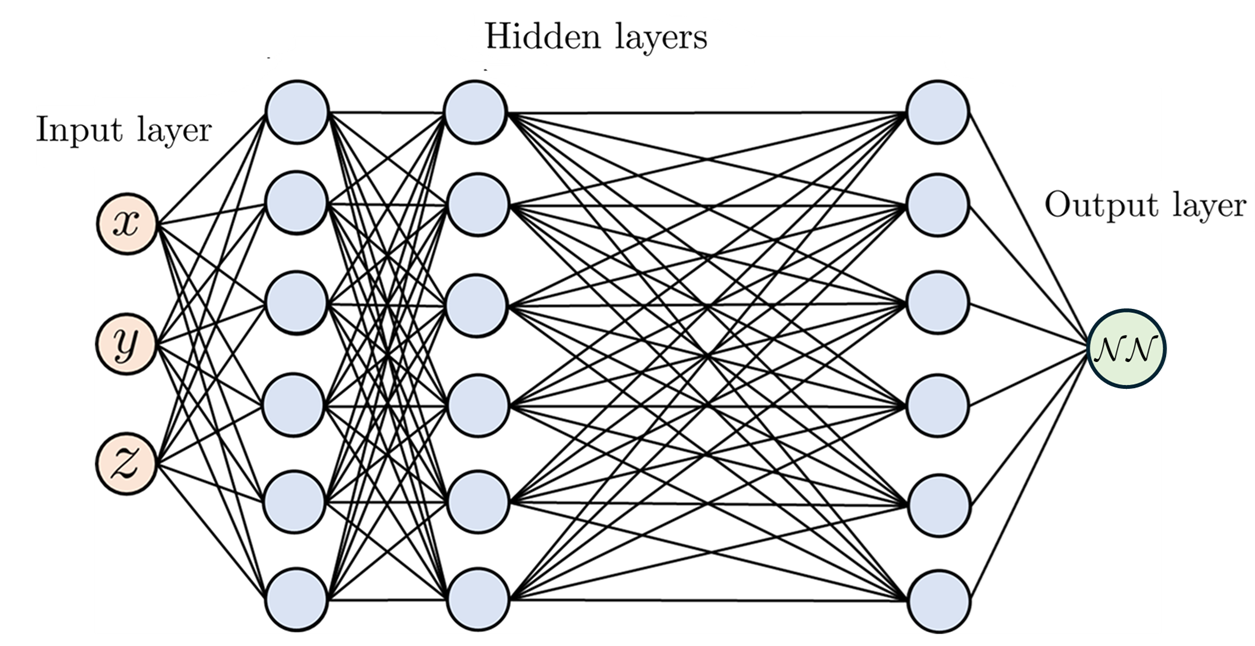

Substituting neural networks for $f(\overrightarrow{r})$ and $g(\overrightarrow{r})$ in Equation (6) is equivalent to minimizing the loss function:

$$
\mathcal{L}\left(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g\right) = \mathcal{L}_{data}\left(\overrightarrow{\theta}_f\right) + \lambda \mathcal{L}_{weak}\left(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g\right),~~~~~~~ (7)
$$

where:

$$
\mathcal{L}_{data}(\overrightarrow{\theta}_f)=\frac{1}{N_p}\displaystyle\sum_{i=1}^{N_p}\left(s_i-\mathcal{NN}_f(\overrightarrow{r}_i,\overrightarrow{\theta}_f)\right)^2,~~~~~~~ (8)
$$

and

\begin{align}\label{fdapinn:7}
        \mathcal{L}_{weak}\left(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g\right)&=\frac{1}{N_T}\displaystyle\sum_{\substack{i,j,k\\t_{ijk}\in I_\Delta}}\left[\int_{t_{ijk}} u(\overrightarrow{r})\overrightarrow{\nabla}^2\left[\mathcal{NN}_g\left(\overrightarrow{r},\overrightarrow{\theta}_g\right)\right]\text{ }d\overrightarrow{r}\right]^2\notag\\
        &+\frac{1}{N_T}\displaystyle\sum_{\substack{i,j,k\\t_{ijk}\in I_\Delta}} \left[\int_{t_{ijk}} v(\overrightarrow{r})\left(\overrightarrow{\nabla}^2\left[\mathcal{NN}_f\left(\overrightarrow{r},\overrightarrow{\theta}_f\right)\right]-\mathcal{NN}_g\left(\overrightarrow{r},\overrightarrow{\theta}_g\right)\right)\text{ }d\overrightarrow{r}\right]^2.~~~~~~~ (9)
\end{align}

The cost function in Equation (9) is composed of two terms. The first term $\mathcal{L}_{data}(\overrightarrow{\theta}_f)$ is a least-squares expression measuring the fit to the data. The second term $\mathcal{L}_{weak}(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g)$ incorporates Equation (6): the function $f(\overrightarrow{r})$ and its curvature $g(\overrightarrow{r})$ are replaced by their neural network approximators $\mathcal{NN}_f(\overrightarrow{r},\overrightarrow{\theta}_f)$ and $\mathcal{NN}_g(\overrightarrow{r},\overrightarrow{\theta}_g)$, respectively. The term $\mathcal{L}_{weak}(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g)$ penalizes deviations from a solution of Equation (6).

So far, $u$ and $v$ were arbitrary functions. We choose these functions so that all boundary terms on integration by parts are zero. Generalizing the choice in [13,14], we set:

\begin{equation}\label{fdapinn:13}
    u(t,w)=v(t,w)=256\left(\left(t-\frac{1}{2}\right)^2-\frac{1}{4}\right)^2\left(\left(w-\frac{1}{2}\right)^2-\frac{1}{4}\right)^2.~~~~~~~ (10)
\end{equation}

These functions are illustrated below for one generic triangle in the brain mesh. They consist of a "bump" in the center of the triangle that goes to zero at the edges.

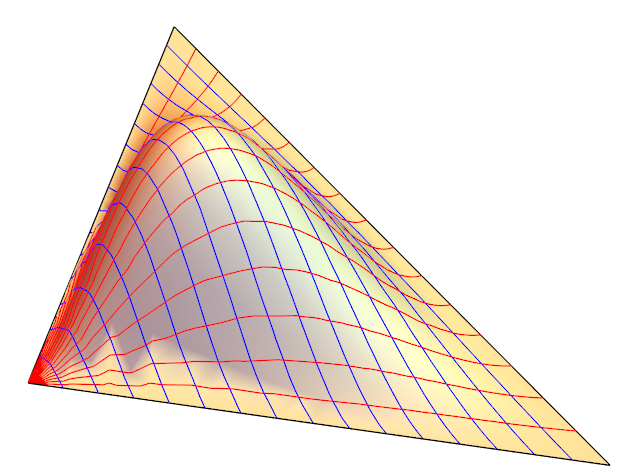

With our choice for $u$ and $v$, Equation (9) can be written:

\begin{align}\label{fdapinn:16}
        \mathcal{L}_{weak}\left(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g\right)&=\frac{1}{N_T}\displaystyle\sum_{\substack{i,j,k\\t_{ijk}\in I_\Delta}}\left(\int_{t_{ijk}} \mathcal{NN}_g\left(\overrightarrow{r},\overrightarrow{\theta}_g\right)\overrightarrow{\nabla}^2u\text{ }d\overrightarrow{r}\right)^2\notag\\
        &+\frac{1}{N_T}\displaystyle\sum_{\substack{i,j,k\\t_{ijk}\in I_\Delta}} \left(\int_{t_{ijk}} \mathcal{NN}_f\left(\overrightarrow{r},\overrightarrow{\theta}_f\right)\overrightarrow{\nabla}^2v-\mathcal{NN}_g\left(\overrightarrow{r},\overrightarrow{\theta}_g\right)v(\overrightarrow{r})\text{ }d\overrightarrow{r}\right)^2.~~~~~~~ (11)
\end{align}

The cost function used to optimize the networks is:

$$
\mathcal{L}\left(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g\right) = \mathcal{L}_{data}\left(\overrightarrow{\theta}_f\right) + \lambda \mathcal{L}_{weak}\left(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g\right),~~~~~~~ (12)
$$

where $\mathcal{L}_{data}\left(\overrightarrow{\theta}_f\right)$ is given by Equation (8) and $\mathcal{L}_{weak}\left(\overrightarrow{\theta}_f,\overrightarrow{\theta}_g\right)$ is given by Equation (11). 

# Implementation

Our model involves a simple MLP neural network architecture to be trained using a cost function involving differential operators. The entire framework of deep learning techniques can be applied straightforwardly. First, we need to convert our data - the brain mesh and the noisy activation measurements - into PyTorch tensors.

In [6]:
# =========================================================================================================================================
# SETTING UP DATASET
# =========================================================================================================================================
# Write dataset as tensors
points = torch.Tensor(VERTICES) # Vertices
faces = torch.Tensor(FACES).long() # Faces
values = torch.Tensor(data).reshape(-1,1) # Measurements

pav = torch.cat((points,values),1) # Vertices and measurements together
faces = pav[faces,:] # Faces as vertex coordinates instead of indices 

Next, we will divide the dataset into batches. This is used later in the Adam optimization algorithm [15] during network training. The use of batches speeds up training while maintaining convergence [16,17]. We choose 5 batches.

In [7]:
# Creating batches
N_batch = 5
batch_size_faces = int(faces.shape[0]/N_batch)
batch_size_pav = int(pav.shape[0]/N_batch)

faces_loader = DataLoader(faces, batch_size_faces, shuffle=True)
pav_loader = DataLoader(pav, batch_size_pav, shuffle=True)

We now set up the neural network class. The class is written in such a way that the user can choose the number of hidden layers (depth) and the number of neurons in each hidden layer (width) of the MLP. We use the hyperbolic tangent as the activation function and initialize the network parameters using Xavier initialization. 

In [8]:
# =========================================================================================================================================
# SETTING UP NEURAL NETWORK 
# =========================================================================================================================================
# Build neural network
class PINN(nn.Module):
    def __init__(self, N_layers, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layers
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linears = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(N_layers-1)])
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        # Xavier initialization
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        for i in range(N_layers-1):
            torch.nn.init.xavier_uniform_(self.linears[i].weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)

    def forward(self, xb, GCV=False): # The GCV variable is used for hyperparameter tuning, which is beyond the scope of this notebook
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function (hyperbolic tangent)
        out = torch.tanh(out)
        for i, l in enumerate(self.linears):
            out = self.linears[i](out)
            out = torch.tanh(out)
        # Get predictions using output layer 
        if GCV == False:
            out = self.linear2(out)
        return out

You can choose the depth and width of the MLP by changing the variables "N_layers" and "hidden_size", respectively. We chose the following values based on a number of works dealing with a similar setting as ours [14,18,19].

In [9]:
# ==========================================================================================================================================
# CHOOSING ARCHITECTURE
# ==========================================================================================================================================
N_layers = 4 # Depth
input_size = 3 # Size of input layer, fixed to three (three Cartesian coordinates)
hidden_size = 50 # Width
output_size = 1 # Size of output layer, fixed to one (scalar function)
# ==========================================================================================================================================
# INSTATIATING NEURAL NETWORKS
# ==========================================================================================================================================
model_f = PINN(N_layers,input_size, hidden_size, out_size=output_size) # MLP for f
model_g = PINN(N_layers,input_size, hidden_size, out_size=output_size) # MLP for g

The following are mathematical functions necessary to calculate the derivatives and integrals that appear in the cost function in Equation (11). You don't need to worry too much about them.

In [10]:
# ==========================================================================================================================================
# USEFUL MATHEMATICAL FUNCTIONS + LOSS
# ==========================================================================================================================================
# Useful mathematical functions - optimized
def w(face,p): # test function (adapted from article)
    u, v = p
    return torch.tile(256*((u-1/2)**2-1/4)**2*((v-1/2)**2-1/4)**2,(face.shape[0],1)) # Number of faces X Number of points in (u,v)-space

def LBO_w(face,p): # Laplace-Beltrami operator of test function w(u, v) for any face in the mesh
    r1 = face[:,0,:-1]
    r2 = face[:,1,:-1]
    r3 = face[:,2,:-1]
    u, v = p
    A = torch.tile(torch.sum((r2-r1)*(r2-r1),dim=1).reshape(1,r1.shape[0]).T,(1,u.shape[0])) #Broadcasting
    B = torch.tile(torch.sum((r3-r2)*(r3-r2),dim=1).reshape(1,r1.shape[0]).T,(1,u.shape[0]))
    C = torch.tile(torch.sum((r3-r2)*(r2-r1),dim=1).reshape(1,r1.shape[0]).T,(1,u.shape[0]))
    num = A*(6*u**2-6*u+1)*(v-1)**2 + C*2*u*(v-1)*(-4*u**2+3*u+3*u*v-2*v) + B*u**2*(3*u**2-2*u**2*v+v**2-2*u)
    den = A*B-C**2
    return 256*2*num/den # Number of faces X Number of points in (u,v)-space

def det(face,p): # determinant of induced metric on any face
    r1 = face[:,0,:-1]
    r2 = face[:,1,:-1]
    r3 = face[:,2,:-1]
    u, v = p
    A = torch.tile(torch.sum((r2-r1)*(r2-r1),dim=1).reshape(1,r1.shape[0]).T,(1,u.shape[0])) #Broadcasting
    B = torch.tile(torch.sum((r3-r2)*(r3-r2),dim=1).reshape(1,r1.shape[0]).T,(1,u.shape[0]))
    C = torch.tile(torch.sum((r3-r2)*(r2-r1),dim=1).reshape(1,r1.shape[0]).T,(1,u.shape[0]))
    return v**2*(A*B-C**2) # Number of faces X Number of points in (u,v)-space

def embedding(face,p): # embedding of face into 3D
    r1 = face[:,0,:-1]
    r2 = face[:,1,:-1]
    r3 = face[:,2,:-1]
    u, v = p
    u = torch.tile(u,(r1.shape[0],3,1))
    v = torch.tile(v,(r1.shape[0],3,1))
    r1 = torch.unsqueeze(r1,-1).repeat(1,1,u.shape[-1])
    r2 = torch.unsqueeze(r2,-1).repeat(1,1,u.shape[-1])
    r3 = torch.unsqueeze(r3,-1).repeat(1,1,u.shape[-1])
    return torch.transpose((1-u)*(r1+v*(r2-r1))+u*(r1+v*(r3-r1)),1,2) # Number of faces X Number of points in (u,v)-space X 3

def GaussLegendre(face,func,NN): # Numerical integration
    X, W = scipy.special.roots_legendre(5) # Number of quadrature points in each dimension
    X = torch.Tensor(X) # quadrature points
    W = torch.Tensor(W) # weights
    u = (X + 1)/2
    v = (X + 1)/2
    p = torch.Tensor([[i,j] for i in u for j in v]).T # quadrature points in (u,v)-space
    WW = torch.tile(torch.Tensor([i*j for i in W for j in W]),(face.shape[0],1))
    func_vec = func(face,p)
    NN_vec  = NN.forward(embedding(face,p)).flatten(start_dim=-2,end_dim=-1)
    det_vec = torch.sqrt(det(face,p))
    return torch.sum(func_vec*NN_vec*det_vec*WW*1/4,dim=1) # Number of faces

# Loss functions
def PINN_data_loss(pav, faces, model_f, model_g): # Corresponds to Equation (8) 
    Rdata = F.mse_loss(torch.flatten(model_f.forward(pav[:,:-1])),pav[:,-1])
    return Rdata 

def PINN_PDE_loss(pav, faces, model_f, model_g): # Corresponds to Equation (11)
    s1 = GaussLegendre(faces,LBO_w,model_g)**2
    s23 = (GaussLegendre(faces,LBO_w,model_f) - GaussLegendre(faces,w,model_g))**2
    return torch.sum(s1 + s23)/faces.shape[0]

We now set up the training functions. We divide the optimization into two stages. The first one involves using Adam [15] to roughly look for a minimum of cost function (12). Afterwards, we fine-tune using L-BFGS [20,21] with the whole dataset (no batches). L-BFGS uses information about the second derivative of the cost function to look for the optimal direction in parameter space and is thus more precise than Adam, which only uses gradient information. However, the former is more computationally intensive. The combination Adam + L-BFGS is common in the PINN literature [18,19,22-25].

In [11]:
# =========================================================================================================================================
# TRAINING FUNCTIONS
# =========================================================================================================================================
def fit_batch(epochs, lr1, hp, pav_loader, faces_loader, model_f, model_g, opt_func=torch.optim.Adam): # Adam (using batches)
    history = []
    PINN_data_vec = []
    PINN_PDE_vec = []
    optimizer = opt_func(list(model_f.parameters()) + list(model_g.parameters()))
    for epoch in range(epochs):
        b = 0
        history_b = []
        PINN_data_vec_b = []
        PINN_PDE_vec_b = []
        for idx, datum in enumerate(zip(pav_loader, faces_loader)):
            pav = datum[0]
            faces = datum[1]
            # Training Phase 
            PINN_data = PINN_data_loss(pav, faces, model_f, model_g)
            PINN_PDE = PINN_PDE_loss(pav, faces, model_f, model_g)
            loss = PINN_data + hp*PINN_PDE # Equation (12)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            history_b.append(loss.item())
            PINN_data_vec_b.append(PINN_data.item())
            PINN_PDE_vec_b.append(PINN_PDE.item())
            learn_res = model_f.forward(points).flatten()
            b = b + 1
        history.append(np.mean(np.array(history_b)))
        PINN_data_vec.append(np.mean(np.array(PINN_data_vec_b)))
        PINN_PDE_vec.append(np.mean(np.array(PINN_PDE_vec_b)))
    return history, PINN_data_vec, PINN_PDE_vec

def fit_batch_2(epochs, lr1, hp, pav, faces, model_f, model_g, opt_func=torch.optim.LBFGS): # L-BFGS (entire dataset, no batches)
    history = []
    PINN_data_vec = []
    PINN_PDE_vec = []
    optimizer = opt_func(list(model_f.parameters()) + list(model_g.parameters()))
    for epoch in range(epochs):
        # Training Phase 
        PINN_data = PINN_data_loss(pav, faces, model_f, model_g)
        PINN_PDE = PINN_PDE_loss(pav, faces, model_f, model_g)
        loss = PINN_data + hp*PINN_PDE # Equation (12)
        def closure():
            optimizer.zero_grad()
            PINN_data = PINN_data_loss(pav, faces, model_f, model_g)
            PINN_PDE = PINN_PDE_loss(pav, faces, model_f, model_g)
            loss = PINN_data + hp*PINN_PDE # Equation (12)
            loss.backward()
            return loss
        optimizer.step(closure)
        history.append(loss.item())
        PINN_data_vec.append(PINN_data.item())
        PINN_PDE_vec.append(PINN_PDE.item())
        learn_res = model_f.forward(points).flatten()
    return history, PINN_data_vec, PINN_PDE_vec

Now, it is time to train the model. We run Adam for 10000 epochs and L-BFGS for 100 epochs. 

Here, a disclaimer is necessary. The brain mesh for this example contains 32492 vertices and 64980 triangles. Such high amount of data naturally takes time to process. In our experiments, using the hyperparameters set out in this notebook (e.g., network width, network depth, number of epochs), training takes around two days and a half on a standard CPU.

In [12]:
# =========================================================================================================================================
# TRAINING PINN
# =========================================================================================================================================
# Training the PINN - Adam
t0 = time.time()

history = []
PINN_data_vec = []
PINN_PDE_vec = []

N_epoch = 10000 # Number of epochs
lr1 = 0.05 # Learning rate (it's not being used, we instead use Adam's default learning rate of 0.001 internally)
hp = 10**(-3) # Smoothing parameter, written as lambda in Equation (12). You can choose its value. We found that 10^(-3) gives reasonable results.

history, PINN_data_vec, PINN_PDE_vec = fit_batch(N_epoch, lr1, hp, pav_loader, faces_loader, model_f, model_g)

print("Adam optimization (s) = ", time.time()-t0)

# Training the PINN - L-BFGS
t0 = time.time()

history2 = []
PINN_data_vec2 = []
PINN_PDE_vec2 = []

N_epoch = 100 # Number of epochs

history2, PINN_data_vec2, PINN_PDE_vec2 = fit_batch_2(N_epoch, lr1, hp, pav, faces, model_f, model_g)

print("L-BFGS optimization (s) = ", time.time()-t0)

history.extend(history2)
PINN_data_vec.extend(PINN_data_vec2)
PINN_PDE_vec.extend(PINN_PDE_vec2)

Adam optimization (s) =  16.380847454071045
L-BFGS optimization (s) =  177.77677631378174


After training, the MLP $\mathcal{NN}_f(\overrightarrow{r},\overrightarrow{\theta})$ should be able to approximate the underlying BOLD signal. We can check the results in a plot.

In [13]:
# =========================================================================================================================================
# PLOTTING RESULTS
# =========================================================================================================================================
res = model_f.forward(points).flatten().detach().numpy()

organ.point_data['Results'] = res

sargs = dict(
    color="black"
)

pl = pv.Plotter()
pl.add_mesh(organ,
            scalars="Results",
            show_edges=False,
            cmap="bwr",
            scalar_bar_args=sargs,
            clim=[min(data),max(data)]
           )

pl.set_background('white')

pl.show()

Widget(value='<iframe src="http://localhost:63804/index.html?ui=P_0x1e3c49eb4c0_2&reconnect=auto" class="pyvis…

For illustration purposes, we show below the results of an experiment with $\lambda=0.001$, which achieved reasonable results.

In [18]:
# =========================================================================================================================================
# PLOTTING EXAMPLE RESULTS - LAMBDA=0.001
# =========================================================================================================================================
example_res = np.loadtxt("results_lambda=0.001.csv",delimiter=",")

organ.point_data['Example_results'] = example_res

sargs = dict(
    color="black"
)

pl = pv.Plotter()
pl.add_mesh(organ,
            scalars="Example_results",
            show_edges=False,
            cmap="bwr",
            scalar_bar_args=sargs,
            clim=[min(data),max(data)]
           )

pl.set_background('white')

pl.show()

Widget(value='<iframe src="http://localhost:63804/index.html?ui=P_0x1e3d89eaa30_3&reconnect=auto" class="pyvis…

Here's a comparison between the original noisy measurements (left) and the smooth estimated BOLD signal for $\lambda=0.001$ (right). It is clear that our model effectively smooths the BOLD signal and mitigates noise levels on the surface, thereby yielding a more precise representation of the subject's brain activity for later analysis.

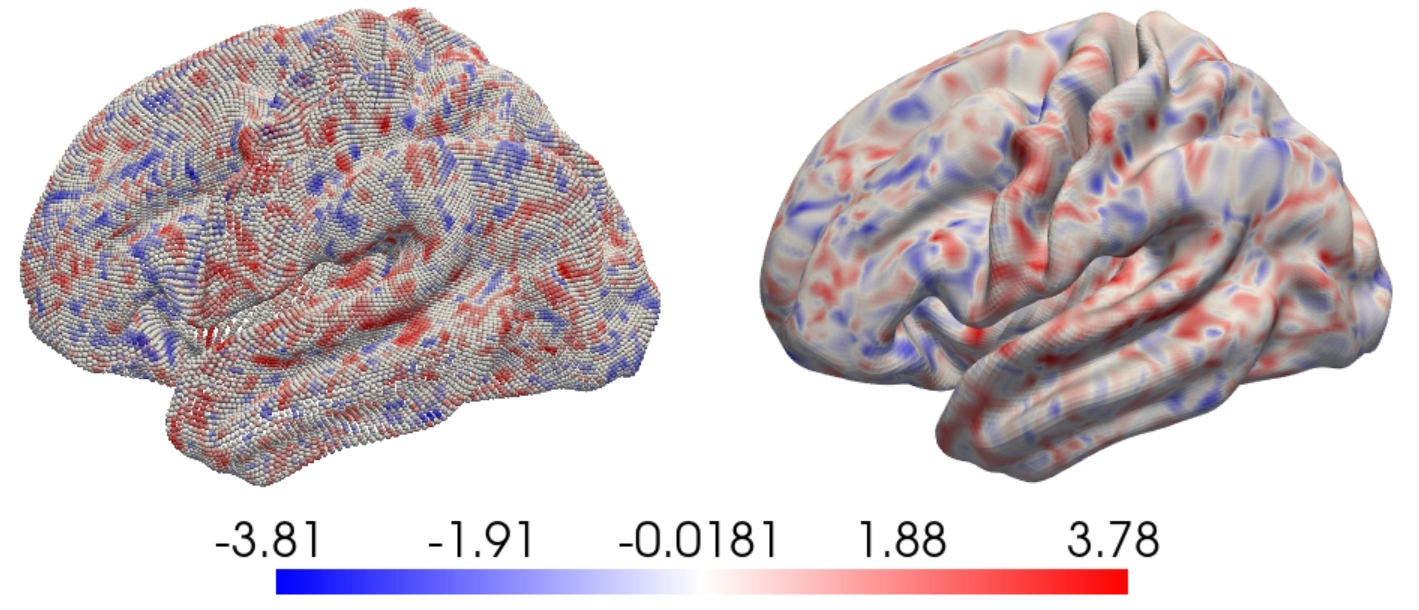

# References

[1] Van Essen, D. C., Ugurbil, K., Auerbach, E., Barch, D., Behrens, T. E., Bucholz, R.,
Chang, A., Chen, L., Corbetta, M., Curtiss, S. W. et al. (2012), ‘The human connectome
project: a data acquisition perspective’, Neuroimage 62(4), 2222–2231;

[2] Glasser, M. F., Sotiropoulos, S. N., Wilson, J. A., Coalson, T. S., Fischl, B., Andersson,
J. L., Xu, J., Jbabdi, S., Webster, M., Polimeni, J. R. et al. (2013), ‘The minimal
preprocessing pipelines for the human connectome project’, Neuroimage 80, 105–124;

[3] Van Essen, D. C., Smith, S. M., Barch, D. M., Behrens, T. E., Yacoub, E., Ugurbil, K.,
Consortium, W.-M. H. et al. (2013), ‘The wu-minn human connectome project: an
overview’, Neuroimage 80, 62–79;

[4] Hodge, M. R., Horton, W., Brown, T., Herrick, R., Olsen, T., Hileman, M. E., McKay,
M., Archie, K. A., Cler, E., Harms, M. P. et al. (2016), ‘Connectomedb—sharing human
brain connectivity data’, Neuroimage 124, 1102–1107;

[5] Binder, J. R., Gross, W. L., Allendorfer, J. B., Bonilha, L., Chapin, J., Edwards, J. C.,
Grabowski, T. J., Langfitt, J. T., Loring, D. W., Lowe, M. J. et al. (2011), ‘Map-
ping anterior temporal lobe language areas with fmri: a multicenter normative study’,
Neuroimage 54(2), 1465–1475;

[6] Ettinger, B., Perotto, S. & Sangalli, L. M. (2016), ‘Spatial regression models over two-
dimensional manifolds’, Biometrika 103(1), 71–88;

[7] Ponti, L., Perotto, S. & Sangalli, L. M. (2022), ‘A pde-regularized smoothing method
for space–time data over manifolds with application to medical data’, International
Journal for Numerical Methods in Biomedical Engineering 38(12), e3650;

[8] Rosenberg, S. (1997), The Laplacian on a Riemannian manifold: an introduction to anal-
ysis on manifolds, number 31, Cambridge University Press;

[9] Baez, J. C. & Muniain, J. P. (1994), Gauge fields, knots and gravity, Vol. 4, World
Scientific Publishing Company;

[10] Liu, G.-R. & Quek, S. S. (2013), The finite element method: a practical course,
Butterworth-Heinemann;

[11] Raissi, M., Perdikaris, P. & Karniadakis, G. E. (2017a), ‘Physics informed deep learning
(part i): Data-driven solutions of nonlinear partial differential equations’, arXiv preprint
arXiv:1711.10561;

[12] Raissi, M., Perdikaris, P. & Karniadakis, G. E. (2017b), ‘Physics informed deep learn-
ing (part ii): Data-driven solutions of nonlinear partial differential equations’, arXiv
preprint arXiv:1711.10566;

[13] Reinbold, P. A., Gurevich, D. R. & Grigoriev, R. O. (2020), ‘Using noisy or incomplete
data to discover models of spatiotemporal dynamics’, Physical Review E 101(1), 010203;

[14] Xu, R., Zhang, D., Rong, M. & Wang, N. (2021), ‘Weak form theory-guided neural
network (tgnn-wf) for deep learning of subsurface single-and two-phase flow’, Journal
of Computational Physics 436, 110318;

[15] Kingma, D. P. (2014), ‘Adam: A method for stochastic optimization’, arXiv preprint
arXiv:1412.6980;

[16] Jentzen, A., Kuckuck, B., Neufeld, A. & von Wurstemberger, P. (2021), ‘Strong error
analysis for stochastic gradient descent optimization algorithms’, IMA Journal of Nu-
merical Analysis 41(1), 455–492;

[17] Garrigos, G. & Gower, R. M. (2023), ‘Handbook of convergence theorems for (stochastic)
gradient methods’, arXiv preprint arXiv:2301.11235;

[18] Sahli Costabal, F., Yang, Y., Perdikaris, P., Hurtado, D. E. & Kuhl, E. (2020a), ‘Physics-
informed neural networks for cardiac activation mapping’, Frontiers in Physics 8, 42;

[19] Grandits, T., Pezzuto, S., Costabal, F. S., Perdikaris, P., Pock, T., Plank, G. & Krause,
R. (2021), Learning atrial fiber orientations and conductivity tensors from intracardiac
maps using physics-informed neural networks, in ‘International Conference on Func-
tional Imaging and Modeling of the Heart’, Springer, pp. 650–658;

[20] Nocedal, J. (1980), ‘Updating quasi-newton matrices with limited storage’, Mathematics
of computation 35(151), 773–782;

[21] Liu, D. C. & Nocedal, J. (1989), ‘On the limited memory bfgs method for large scale
optimization’, Mathematical programming 45(1), 503–528;

[22] Cuomo, S., Di Cola, V. S., Giampaolo, F., Rozza, G., Raissi, M. & Piccialli, F. (2022),
‘Scientific machine learning through physics–informed neural networks: Where we are
and what’s next’, Journal of Scientific Computing 92(3), 88;

[23] Caforio, F., Regazzoni, F., Pagani, S., Karabelas, E., Augustin, C., Haase, G., Plank,
G. & Quarteroni, A. (2024), ‘Physics-informed neural network estimation of material
properties in soft tissue nonlinear biomechanical models’, Computational Mechanics
pp. 1–27;

[24] Hasan, F., Ali, H. & Arief, H. A. (2025), ‘From mesh to neural nets: A multi-method
evaluation of physics informed neural network and galerkin finite element method for
solving nonlinear convection–reaction–diffusion equations’, International Journal of Ap-
plied and Computational Mathematics 11(3), 1–24;

[25] Deresse, A. T. & Bekela, A. S. (2025), ‘A deep learning approach: physics-informed neural
networks for solving a nonlinear telegraph equation with different boundary conditions’,
BMC Research Notes 18(1), 77.